# 概要

PyTorchを使ってLSTMで文章分類を実装してみた。    
前回のSeq2Seqの実装に引き続き、今回はSeq2SeqにAttentionを加えたAttention Seq2SeqをPyTorchで実装してみました。  

自分みたいな初学者でもわかりやすくPyTorchでAttentionを実装しているソースコードがあまり見つからず、PyTorchのAttentionのチュートリアルもあるにはあるのですが、ミニバッチ学習してない(?)っぽいし、このタスク用にあれこれカスタマイズされてそうな感じでもっとシンプルにプレーン(?)なAttentionの実装をしてみたかった、ということで自分でAttentionを実装してみました。  
Attentionの実装に手こずっている人に少しでもご参考になる情報をお届けできれば幸いです。  

Attentionの仕組みはやはりゼロから作るDeep Learning ❷ ―自然言語処理編が圧倒的にわかりやすかったです。  

これからご紹介する実装例は、ゼロ作2のスクラッチによる実装をただPyTorchで真似ただけ(になってるはず)なので、本記事がわかりにくかったら、ゼロ作2を一読されることを強くおすすめします。  

https://qiita.com/m__k/items/646044788c5f94eadc8d

## 補足
Attentionにもsoft Attention、hard Attentionなどいろいろあるかと思いますが、ここでいうAttentionはゼロから作るDeep Learning ❷ ―自然言語処理編で説明されている(softな)Attentionを指すことにします。

# Attentionの仕組み
## Seq2Seqの課題
Seq2SeqはEncoderがインプットの系列の長さによらず、固定長ベクトルに変換してしまうので、長い系列などは特徴が捉えきれない、という課題があります。  
Attentionは、この課題を解決すべく、Encoder側のインプットの系列の長さを考慮できる仕組みを用意します。  

## 超ざっくり説明
超ざっくりとAttentionの説明をすると  

1. Encoder側の各隠れ層の値をすべてDecoder側の各層に渡す  
1. Decoder側の各層において、Encoder側から渡された各隠れ層のベクトルのうち、最も注意すべきベクトルを選び出して特徴に加える  

という操作をします。  
1.において、Encoder側の隠れ層ベクトルの数は、Encoder側のインプットとなる系列の長さに依存するので、系列の長さを考慮した形になっている  
2.において、選び出すという操作は微分できないが、各要素のどこに注意すべきかを$softmax$で確率的に重み付けした形で選ぶ操作を行います。  

## もう少し詳細にAttentionの処理の流れを図を使って説明
以下の図は簡単のために、Encoder側のインプットの系列がw1, w2, w3の3つのとき、Decoder側がw'1, w'2の2つのケースを扱っています。  

①  
Encoder側の各隠れ層の値をそれぞれ$h_{1}$,$h_{2}$, ⋯⋯, $h_{n}$としたとき、$hs$=[$h_{1}$, $h_{2}$,⋯, $h_{n}$] をDecoder側の各層に渡す。  

<center><img src="./doc/image/4-1.png" width=800" align="center"/></center>

②  
Decoder側の各隠れ層のベクトル(ここでは$d_{i}$とする)と、$h_{s}$の各ベクトル$h_{1}$,$h_{2}$,⋯との内積を計算する。  
これはDecoder側の各ベクトルと$hs$の各ベクトルがどれだけ似ているかを計算していることを意味する。（内積は$(⋅,⋅)$で表記してます。）

<center><img src="./doc/image/4-2.png" width="800" align="center"/></center>

③  
②で計算した内積を$softmax$で確率表現に変換する（これをattention weightとか言ったりする）
<center><img src="./doc/image/4-3.png" width="800" align="center"/></center>
attention weightの1行目は、Encoderの1番目のLSTM/GRUが出力した隠れ状態に対するattention、<br/>
2行目は、Encoderの2番目のLSTM/GRUが出力した隠れ状態に対するattention、<br/>
：<br/>
$attention\ weight$ = $[[1番目の単語のweight]]$<br/>
　　　　　　　　　　$[2番目の単語のweight]$<br/>
　　　　　　　　　　$[3番目の単語のweight]$<br/>
　　　　　　　　　　：<br/>
　　　　　　　　　　$[N番目の単語のweight]]$<br/>

④  
$hs$の各要素をattention weightで重み付けして全部足しあわせて1本のベクトルとする（これをコンテキストベクトルとかいったりする）
<center><img src="./doc/image/4-4.png" width="600" align="center"/></center>

⑤  
コンテキストベクトルと$d_{i}$を結合して、1本のベクトルにする
<center><img src="./doc/image/4-5.png" width="800" align="center"/></center>

# 実装
- 上で説明した1~5の処理をDecoder側に加えれば完成です。ゼロ作2と同様に日付フォーマットの変換問題を扱います。（attention weightを可視化したとき確からしさが確認しやすいため）
- 以下はGoogle Colab上で実装しています。
- 前回で説明したSeq2Seqの実装にAttentionの処理を加える形で説明するので、大部分は前回のソースを使いまわしています。前回のソースコードもぜひご参照ください。
  - PyTorchでSeq2Seqを実装してみた

## 問題設定
以下のような様々な日付の書き方をYYYY-MM-DDのフォーマットに変換するタスクをAttention seq2seqで解かせてみます。

<center><img src="./doc/image/4-9.png" width="300" align="center"/></center>

In [36]:
import os
from glob import glob
import pandas as pd
import seaborn as sns
import numpy as np
import linecache
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
%matplotlib inline

## データ準備
https://github.com/oreilly-japan/deep-learning-from-scratch-2/raw/master/dataset/date.txt
を入手する。

In [10]:
file_path = r"date.txt"
if not os.path.exists(file_path):
    !wget https://github.com/oreilly-japan/deep-learning-from-scratch-2/raw/master/dataset/date.txt
else:
    print("date.txt exists.")

date.txt exists.


In [13]:
input_date = [] # 変換前の日付データ
output_date = [] # 変換後の日付データ

# date.txtを1行ずつ読み込んで変換前と変換後に分割して、inputとoutputで分ける
with open(file_path, "r") as f:
  date_list = f.readlines()
  for date in date_list:
    date = date[:-1]
    input_date.append(date.split("_")[0])
    output_date.append("_" + date.split("_")[1])

print(input_date[:5])
print(output_date[:5])

['september 27, 1994           ', 'August 19, 2003              ', '2/10/93                      ', '10/31/90                     ', 'TUESDAY, SEPTEMBER 25, 1984  ']
['_1994-09-27', '_2003-08-19', '_1993-02-10', '_1990-10-31', '_1984-09-25']


In [14]:
# inputとoutputの系列の長さを取得
# すべて長さが同じなので、0番目の要素でlenを取ってます
input_len = len(input_date[0]) # 29
output_len = len(output_date[0]) # 10

print(f"input_len:{input_len}")
print(f"output_len:{output_len}")

input_len:29
output_len:11


In [15]:
# date.txtで登場するすべての文字にIDを割り当てる
char2id = {}
for input_chars, output_chars in zip(input_date, output_date):
  for c in input_chars:
    if not c in char2id:
      char2id[c] = len(char2id)
  for c in output_chars:
    if not c in char2id:
      char2id[c] = len(char2id)

print(char2id)

{'s': 0, 'e': 1, 'p': 2, 't': 3, 'm': 4, 'b': 5, 'r': 6, ' ': 7, '2': 8, '7': 9, ',': 10, '1': 11, '9': 12, '4': 13, '_': 14, '-': 15, '0': 16, 'A': 17, 'u': 18, 'g': 19, '3': 20, '8': 21, '/': 22, 'T': 23, 'U': 24, 'E': 25, 'S': 26, 'D': 27, 'Y': 28, 'P': 29, 'M': 30, 'B': 31, 'R': 32, '5': 33, 'J': 34, 'N': 35, '6': 36, 'a': 37, 'i': 38, 'l': 39, 'O': 40, 'c': 41, 'o': 42, 'G': 43, 'F': 44, 'y': 45, 'n': 46, 'C': 47, 'W': 48, 'd': 49, 'I': 50, 'L': 51, 'j': 52, 'H': 53, 'v': 54, 'h': 55, 'V': 56, 'f': 57, 'w': 58}


In [16]:
input_data = [] # ID化された変換前日付データ
output_data = [] # ID化された変換後日付データ
for input_chars, output_chars in zip(input_date, output_date):
  input_data.append([char2id[c] for c in input_chars])
  output_data.append([char2id[c] for c in output_chars])

# 7:3でtrainとtestに分ける
train_x, test_x, train_y, test_y = train_test_split(input_data, output_data, train_size= 0.7)

In [17]:
# データをバッチ化するための関数を定義
def train2batch(input_data, output_data, batch_size=100):
    input_batch = []
    output_batch = []
    input_shuffle, output_shuffle = shuffle(input_data, output_data)
    for i in range(0, len(input_data), batch_size):
      input_batch.append(input_shuffle[i:i+batch_size])
      output_batch.append(output_shuffle[i:i+batch_size])
    return input_batch, output_batch

## Encoder
- Encoder側はほとんど前回実装したseq2seqから変わりません。
- 少しでも楽したいので、LSTMはGRUに変えてます。
- GRUの各隠れ層の値はDecoder側でAttentionされるために使うので、GRUの第１戻り値($hs$)も受け取ってます。

In [19]:
# 諸々のパラメータなど
embedding_dim = 200
hidden_dim = 128
BATCH_NUM = 100
vocab_size = len(char2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
# Encoderクラス
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, sequence):
        embedding = self.word_embeddings(sequence)
        # hsが各系列のGRUの隠れ層のベクトル
        # Attentionされる要素
        hs, h = self.gru(embedding)
        return hs, h

## Decoder
- こっちもEncoder側と同様に前回と比べてLSTMをGRUに変えてます。
- 紙とかに各層のテンソルのどの軸がなんの意味なのかを書きながら実装すると頭が整理できます。
- 少しでも理解の助けになるためにAttention層の各テンソルのサイズも記載してみました。

In [42]:
test_x = torch.randn(4, 3, 2)
print("test_x")
print(test_x.size())
print(test_x)
print("-" * 100)

test_x2 = torch.transpose(test_x, 0, 1)
print(test_x2.size())
print(test_x2)
print("-" * 100)

test_x3 = torch.transpose(test_x, 1, 2)
print(test_x3.size())
print(test_x3)
print("-" * 100)

test_x
torch.Size([4, 3, 2])
tensor([[[ 0.5443, -0.4202],
         [ 0.6082, -1.1414],
         [-0.0353, -0.1106]],

        [[-2.4696,  1.5686],
         [-0.4551,  1.1029],
         [ 2.2562, -0.6050]],

        [[-1.7866, -0.1211],
         [ 0.7173, -0.3112],
         [ 0.4281,  0.0514]],

        [[-0.1109, -0.5966],
         [-1.0941,  0.0713],
         [ 0.5763, -0.7629]]])
----------------------------------------------------------------------------------------------------
torch.Size([3, 4, 2])
tensor([[[ 0.5443, -0.4202],
         [-2.4696,  1.5686],
         [-1.7866, -0.1211],
         [-0.1109, -0.5966]],

        [[ 0.6082, -1.1414],
         [-0.4551,  1.1029],
         [ 0.7173, -0.3112],
         [-1.0941,  0.0713]],

        [[-0.0353, -0.1106],
         [ 2.2562, -0.6050],
         [ 0.4281,  0.0514],
         [ 0.5763, -0.7629]]])
----------------------------------------------------------------------------------------------------
torch.Size([4, 2, 3])
tensor([[[ 0.54

In [43]:
# Attention Decoderクラス
class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
        super(AttentionDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=char2id[" "])
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        # hidden_dim*2としているのは、各系列のGRUの隠れ層とAttention層で計算したコンテキストベクトルをtorch.catでつなぎ合わせることで長さが２倍になるため
        self.hidden2linear = nn.Linear(hidden_dim * 2, vocab_size)
        # 列方向を確率変換したいのでdim=1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, sequence, hs, h):
        embedding = self.word_embeddings(sequence)
        output, state = self.gru(embedding, h)

        # Attention層
        # hs.size() = ([100, 29, 128])
        # output.size() = ([100, 10, 128])

        # bmmを使ってEncoder側の出力(hs)とDecoder側の出力(output)をbatchごとまとめて行列計算するために、Decoder側のoutputをbatchを固定して転置行列を取る
        # ※torch.transpose(TENSOR, A, B)
        # 　→ テンソルTENSORのA次元目とB次元目を転置する。
        t_output = torch.transpose(output, 1, 2) # t_output.size() = ([100, 128, 10])

        # bmmで、Encoder側の出力(hs)とDecoder側の出力(output)をバッチも考慮してまとめて行列計算
        # つまり[100, 29, 128]hsと[100, 128, 10]outputの行列積の計算をおこなう。
        s = torch.bmm(hs, t_output) # s.size() = ([100, 29, 10])

        # 列方向(dim=1)でsoftmaxをとって確率表現に変換
        # この値を後のAttentionの可視化などにも使うため、returnで返しておく
        attention_weight = self.softmax(s) # attention_weight.size() = ([100, 29, 10])

        # コンテキストベクトルをまとめるために入れ物を用意
        c = torch.zeros(self.batch_size, 1, self.hidden_dim, device=device) # c.size() = ([100, 1, 128])

        # 各DecoderのGRU層に対するコンテキストベクトルをまとめて計算する方法がわからなかったので、
        # 各層（Decoder側のGRU層は生成文字列が10文字なので10個ある）におけるattention weightを取り出してforループ内でコンテキストベクトルを１つずつ作成する
        # バッチ方向はまとめて計算できたのでバッチはそのまま
        for i in range(attention_weight.size()[2]): # 10回ループ

          # attention_weight[:,:,i].size() = ([100, 29])
          # i番目のGRU層に対するattention weightを取り出すが、テンソルのサイズをhsと揃えるためにunsqueezeする
          unsq_weight = attention_weight[:,:,i].unsqueeze(2) # unsq_weight.size() = ([100, 29, 1])

          # hsの各ベクトルをattention weightで重み付けする
          weighted_hs = hs * unsq_weight # weighted_hs.size() = ([100, 29, 128])

          # attention weightで重み付けされた各hsのベクトルをすべて足し合わせてコンテキストベクトルを作成
          weight_sum = torch.sum(weighted_hs, axis=1).unsqueeze(1) # weight_sum.size() = ([100, 1, 128])

          c = torch.cat([c, weight_sum], dim=1) # c.size() = ([100, i, 128])

        # 箱として用意したzero要素が残っているのでスライスして削除
        c = c[:,1:,:]

        output = torch.cat([output, c], dim=2) # output.size() = ([100, 10, 256])
        output = self.hidden2linear(output)
        return output, state, attention_weight

## モデル宣言、損失関数、最適化
前回と特に変更なし

In [22]:
encoder = Encoder(vocab_size, embedding_dim, hidden_dim).to(device)
attn_decoder = AttentionDecoder(vocab_size, embedding_dim, hidden_dim, BATCH_NUM).to(device)

# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
attn_decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=0.001)

## 学習
- Encoderのアウトプットである${hs}$を忘れずにAttention Decoderに渡せばOK
- EncoderもDecoderもインプットとアウトプットに変更がないので、ほとんど前回のSeq2Seqのときと同じでOK
- ものすごい勢いでlossが減っていきます
- 以下ではlossの下限を0.1に設定してますが、16epoch目にしてもう到達してしまいます。

In [23]:
BATCH_NUM=100
EPOCH_NUM = 100

all_losses = []
print("training ...")
for epoch in range(1, EPOCH_NUM+1):
    epoch_loss = 0
    # データをミニバッチに分ける
    input_batch, output_batch = train2batch(train_x, train_y, batch_size=BATCH_NUM)
    for i in range(len(input_batch)):

        # 勾配の初期化
        encoder_optimizer.zero_grad()
        attn_decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_tensor = torch.tensor(input_batch[i], device=device)
        output_tensor = torch.tensor(output_batch[i], device=device)

        # Encoderの順伝搬
        hs, h = encoder(input_tensor)

        # Attention Decoderのインプット
        source = output_tensor[:, :-1]

        # Attention Decoderの正解データ
        target = output_tensor[:, 1:]

        loss = 0
        decoder_output, _, attention_weight= attn_decoder(source, hs, h)
        for j in range(decoder_output.size()[1]):
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()

        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        encoder_optimizer.step()
        attn_decoder_optimizer.step()

    # 損失を表示
    print("Epoch %d: %.2f" % (epoch, epoch_loss))
    all_losses.append(epoch_loss)
    if epoch_loss < 0.1: break
print("Done")

training ...
Epoch 1: 1491.27
Epoch 2: 95.86
Epoch 3: 58.69
Epoch 4: 28.38
Epoch 5: 21.89
Epoch 6: 19.97
Epoch 7: 26.15
Epoch 8: 3.63
Epoch 9: 1.26
Epoch 10: 0.78
Epoch 11: 0.54
Epoch 12: 0.40
Epoch 13: 0.30
Epoch 14: 0.24
Epoch 15: 0.19
Epoch 16: 0.15
Epoch 17: 0.12
Epoch 18: 0.10
Done


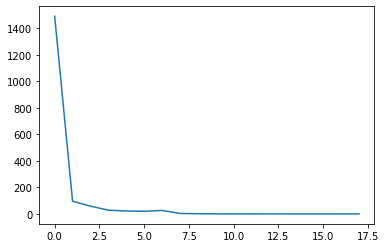

In [26]:
plt.plot(all_losses)

## 予測
- 前回のSeq2Seqのときの予測とほぼ同じ方法で予測させてます。

In [27]:
# Decoderのアウトプットのテンソルから要素が最大のインデックスを返す。つまり生成文字を意味する
def get_max_index(decoder_output):
  results = []
  for h in decoder_output:
    results.append(torch.argmax(h))
  return torch.tensor(results, device=device).view(BATCH_NUM, 1)

In [28]:
# 評価用データ
test_input_batch, test_output_batch = train2batch(test_x, test_y)
input_tensor = torch.tensor(test_input_batch, device=device)

In [29]:
predicts = []
for i in range(len(test_input_batch)):
  with torch.no_grad():
    hs, encoder_state = encoder(input_tensor[i])

    # Decoderにはまず文字列生成開始を表す"_"をインプットにするので、"_"のtensorをバッチサイズ分作成
    start_char_batch = [[char2id["_"]] for _ in range(BATCH_NUM)]
    decoder_input_tensor = torch.tensor(start_char_batch, device=device)

    decoder_hidden = encoder_state
    batch_tmp = torch.zeros(100,1, dtype=torch.long, device=device)
    for _ in range(output_len - 1):
      decoder_output, decoder_hidden, _ = attn_decoder(decoder_input_tensor, hs, decoder_hidden)
      # 予測文字を取得しつつ、そのまま次のdecoderのインプットとなる
      decoder_input_tensor = get_max_index(decoder_output.squeeze())
      batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)
    predicts.append(batch_tmp[:,1:])

In [30]:
# 予測結果を見る際にIDのままだと可読性が悪いので、もとの文字列に復元するためのID→文字列に変換する辞書を定義
id2char = {}
for k, v in char2id.items():
  id2char[v] = k

In [31]:
row = []
for i in range(len(test_input_batch)):
  batch_input = test_input_batch[i]
  batch_output = test_output_batch[i]
  batch_predict = predicts[i]
  for inp, output, predict in zip(batch_input, batch_output, batch_predict):
    x = [id2char[idx] for idx in inp]
    y = [id2char[idx] for idx in output[1:]]
    p = [id2char[idx.item()] for idx in predict]

    x_str = "".join(x)
    y_str = "".join(y)
    p_str = "".join(p)

    judge = "O" if y_str == p_str else "X"
    row.append([x_str, y_str, p_str, judge])
predict_df = pd.DataFrame(row, columns=["input", "answer", "predict", "judge"])
predict_df.head()

,input,answer,predict,judge
0,1/22/98,1998-01-22,1998-01-22,O
1,"December 10, 1986",1986-12-10,1986-12-10,O
2,"thursday, june 4, 2015",2015-06-04,2015-06-04,O
3,"JANUARY 16, 1974",1974-01-16,1974-01-16,O
4,6/21/81,1981-06-21,1981-06-21,O


### 正解率
- 今回たまたま100%ではなかったですが、だいたい100%の正答率になると思います。
- 本タスクを間違えるときはだいたい以下のようなスラッシュ区切りの日付フォーマットが多いように感じます。

In [32]:
print(len(predict_df.query('judge == "O"')) / len(predict_df))

predict_df.query('judge == "X"').head(10)

1.0


,input,answer,predict,judge


## attention weight 可視化
- Attentionの醍醐味の1つであるattention weightの可視化をしてみます。
- attention weightを見ることで学習の確からしさを確認することができます。
- attention weightの可視化にはよくheatmapが使われるので、seabornのheatmapで可視化してます。
- 7:3に分けた3のほうのテストデータをバッチに分けたうちの最初のミニバッチを流しています。

In [33]:
input_batch, output_batch = train2batch(test_x, test_y, batch_size=BATCH_NUM)
input_minibatch, output_minibatch = input_batch[0], output_batch[0]

In [34]:
with torch.no_grad():
  # データをテンソルに変換
  input_tensor = torch.tensor(input_minibatch, device=device)
  output_tensor = torch.tensor(output_minibatch, device=device)
  hs, h = encoder(input_tensor)
  source = output_tensor[:, :-1]
  decoder_output, _, attention_weight= attn_decoder(source, hs, h)


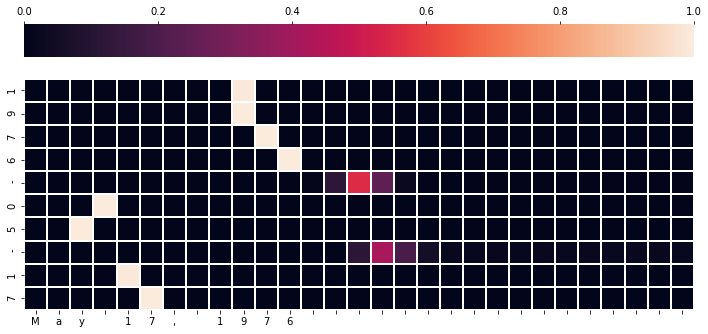

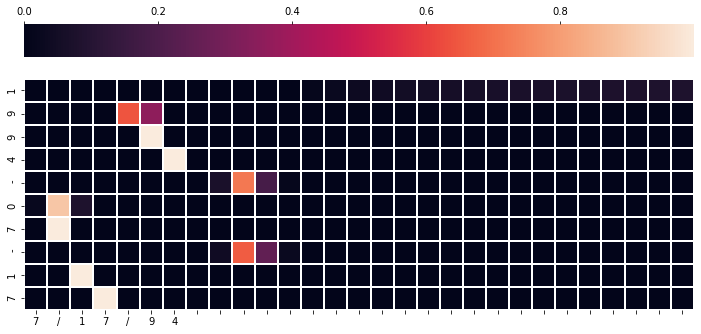

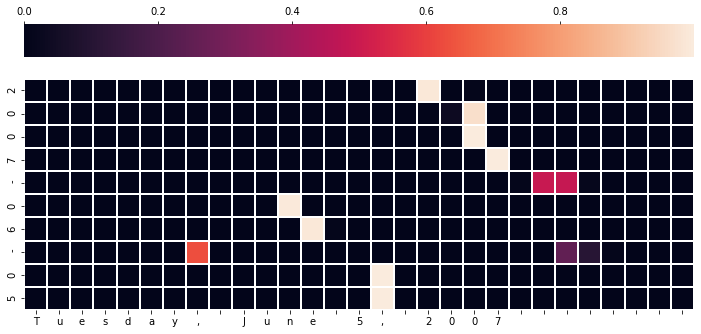

In [37]:
for i in range(3):
  with torch.no_grad():
    df = pd.DataFrame(data=torch.transpose(attention_weight[i], 0, 1).cpu().numpy(), 
                      columns=[id2char[idx.item()] for idx in input_tensor[i]], 
                      index=[id2char[idx.item()] for idx in output_tensor[i][1:]])
    plt.figure(figsize=(12, 8)) 
    sns.heatmap(df, xticklabels = 1, yticklabels = 1, square=True, linewidths=.3,cbar_kws = dict(use_gridspec=False,location="top"))

### 可視化をいくつか紹介
<center><img src="./doc/image/4-6.png" width="800" align="center"/></center>

少々見づらくて恐縮ですが、上図の下の文字「Tuesday, March 27, 2012」が変換前の文字列（Encoderのインプット）で、左の縦に並んでいる「2012-03-27」が生成文字です。  
このheatmapの見方ですが、Decoderの生成文字を１文字ずつ見たとき、左に並んでいるボックスの色が一番明るいところの文字に一番attentionして生成された文字ですよ、という意味になると思います。（違ってたらご指摘ください...）  
(もちろん左方向にボックスの値をすべて足せば1になりますね。)  

上図の例だと、以下のことがわかるのではないかと思います。  

- 全体的にYYYYを生成するなら年の部分、MMを生成するなら月の部分に注目していることが伺えます。
- 今回のタスクはYYYY-MM-DDへの変換、つまり曜日は変換されないので、「Tuesday」にはどの生成文字も注目していない
- 「March」の「a」の部分を「0」がattentionしてます。「May」なら「05」、「March」なら「04」ですが、「Ma」と文字が並べば「0」の生成が確定しており、その後「rch」と文字が並んでいるので、最後の「h」に3が注目してるって感じ？

※今回は生成されるべき正解の文字を表示しちゃってます。今回は正答率がほぼ100%なので、同じかと思いますが、ちゃんとやるならDecoderが生成した文字を１文字ずつ集計してattention weightを作成したほうが良いんだろうなぁと思います。手抜きで申し訳ございません...

他にもこんな感じでAttentionされてます↓

<center><img src="./doc/image/4-7.png" width="800" align="center"/></center>
<center><img src="./doc/image/4-8.png" width="800" align="center"/></center>